## We did Data Processing before, in predict_gas
- Three datasets are used:
  -  makeup: Monthly composition of gasoline prices (e.g. Refining, Taxes).
  - gas_prices: Weekly gasoline retail prices.
  - brent: Daily crude oil prices.
- Alignment of time frequencies:
  - Monthly makeup data is interpolated to weekly values using linear interpolation.
  - Daily brent prices are aggregated to weekly averages.
  - The result  **gas_brent_linear** is a weekly-aligned dataset with: Weekly gas prices, Weekly estimates of the components (Refining, Taxes, etc.), Weekly Brent crude oil averages.

In [16]:
import pandas as pd
gas_data = pd.read_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_linear.csv", index_col=0)
gas_data = gas_data.rename(columns={"Price": "Gas_Price"})
gas_data.columns


Index(['Date', 'Year', 'Type', 'Type_Clean', 'Unit', 'Geography', 'Gas_Price',
       'Month', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price'],
      dtype='object')

We'll do predictions for this:

In [17]:
stock_data = pd.read_csv("datathon data/all_stocks_and_etfs.csv")
stock_data.columns

Index(['Date-Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker_Symbol'], dtype='object')

### Feature Engineering

Computes log-returns and percentage changes for:
- Retail gasoline prices,
- Each price component (Refining, Taxes, etc.),
- Crude oil prices.
- Generates lagged features (e.g., previous 1 to 4 months' returns) to examine delayed effects.

In [18]:
import numpy as np
for col in ['Gas_Price', 'Brent_Price', 'Refining', 'Taxes', 'Distribution_and_Marketing', 'Crude_Oil']:
    gas_data[f'{col}_logreturn'] = np.log(gas_data[col] / gas_data[col].shift(1))
    gas_data[f'{col}_pct'] = gas_data[col].pct_change()
lag = 1
gas_data[f'Gas_Price_lag_{lag}'] = gas_data['Gas_Price'].shift(lag)
gas_data = gas_data.dropna()
gas_data

/home/love/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/love/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Year,Type,Type_Clean,Unit,Geography,Gas_Price,Month,Refining,Distribution_and_Marketing,...,Brent_Price_pct,Refining_logreturn,Refining_pct,Taxes_logreturn,Taxes_pct,Distribution_and_Marketing_logreturn,Distribution_and_Marketing_pct,Crude_Oil_logreturn,Crude_Oil_pct,Gas_Price_lag_1
1,2000-01-10,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.264,1,9.82,11.90,...,-0.071677,0.230297,0.258974,-0.012539,-0.012461,-0.088411,-0.084615,-0.010672,-0.010616,1.272
2,2000-01-17,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.277,1,11.84,10.80,...,0.064769,0.187063,0.205703,-0.012699,-0.012618,-0.096992,-0.092437,-0.010788,-0.010730,1.264
3,2000-01-24,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.315,1,13.86,9.70,...,0.064031,0.157523,0.170608,-0.012862,-0.012780,-0.107420,-0.101852,-0.010905,-0.010846,1.277
4,2000-01-31,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.316,1,15.88,8.60,...,0.015496,0.136053,0.145743,-0.013030,-0.012945,-0.120364,-0.113402,-0.011025,-0.010965,1.315
5,2000-02-07,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.325,2,17.90,7.50,...,0.018667,0.119740,0.127204,-0.013202,-0.013115,-0.136859,-0.127907,-0.011148,-0.011086,1.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2023-11-27,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.238,11,8.25,19.45,...,-0.010910,0.006079,0.006098,0.014185,0.014286,-0.002567,-0.002564,-0.003540,-0.003534,3.289
1248,2023-12-04,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.231,12,8.30,19.40,...,-0.002720,0.006042,0.006061,0.013986,0.014085,-0.002574,-0.002571,-0.003552,-0.003546,3.238
1249,2023-12-11,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.136,12,8.30,19.40,...,-0.063833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.231
1250,2023-12-18,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.053,12,8.30,19.40,...,0.009351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.136


In [19]:
gas_data["Date"] = pd.to_datetime(gas_data["Date"])
stock_data["Date"] = pd.to_datetime(stock_data["Date-Time"])

label_col = 'Close_logreturn' #'Close_diff'
stock_data[label_col] = np.log(stock_data['Close'] / stock_data['Close'].shift(lag)) #stock_data['Close'] - stock_data['Close'].shift(1)
stock_data[f'Close_lag_{lag}'] = stock_data['Close'].shift(lag)

stock_data = stock_data[["Date", "Ticker_Symbol", f'Close_lag_{lag}', label_col]]
stock_data

,Date,Ticker_Symbol,Close_lag_1,Close_logreturn
0,2024-01-25,HAL,NaN,NaN
1,2024-01-24,HAL,37.0000,-0.004605
2,2024-01-23,HAL,36.8300,-0.042430
3,2024-01-22,HAL,35.3000,-0.024955
4,2024-01-19,HAL,34.4300,-0.013450
...,...,...,...,...
144553,1999-11-05,SPY,138.0000,-0.000906
144554,1999-11-04,SPY,137.8750,-0.009794
144555,1999-11-03,SPY,136.5312,-0.007582
144556,1999-11-02,SPY,135.5000,-0.006711


align time between the 2datasets:

In [20]:
df = pd.merge(
    left=stock_data,
    right=gas_data,
    on="Date",
    how="inner"
)
df = df.dropna()
df.to_csv("datathon data/stock_data.csv", index=False)
df

,Date,Ticker_Symbol,Close_lag_1,Close_logreturn,Year,Type,Type_Clean,Unit,Geography,Gas_Price,...,Brent_Price_pct,Refining_logreturn,Refining_pct,Taxes_logreturn,Taxes_pct,Distribution_and_Marketing_logreturn,Distribution_and_Marketing_pct,Crude_Oil_logreturn,Crude_Oil_pct,Gas_Price_lag_1
0,2023-12-18,HAL,36.8200,-0.016706,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.053,...,0.009351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.136
1,2023-12-11,HAL,34.4400,0.009536,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.136,...,-0.063833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.231
2,2023-12-04,HAL,36.3300,0.028224,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.231,...,-0.002720,0.006042,0.006061,0.013986,0.014085,-0.002574,-0.002571,-0.003552,-0.003546,3.238
3,2023-11-27,HAL,37.5200,0.004521,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.238,...,-0.010910,0.006079,0.006098,0.014185,0.014286,-0.002567,-0.002564,-0.003540,-0.003534,3.289
4,2023-11-20,HAL,38.2100,-0.000262,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.289,...,-0.013466,0.006116,0.006135,0.014389,0.014493,-0.002561,-0.002558,-0.003527,-0.003521,3.349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26670,2000-02-14,SPY,141.0781,-0.011249,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.356,...,0.005090,-0.035540,-0.034916,-0.023530,-0.023256,0.162686,0.176667,0.000000,0.000000,1.325
26671,2000-02-07,SPY,144.3125,-0.013517,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.325,...,0.018667,0.119740,0.127204,-0.013202,-0.013115,-0.136859,-0.127907,-0.011148,-0.011086,1.316
26672,2000-01-31,SPY,140.9375,-0.009804,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.316,...,0.015496,0.136053,0.145743,-0.013030,-0.012945,-0.120364,-0.113402,-0.011025,-0.010965,1.315
26673,2000-01-24,SPY,141.9375,-0.011292,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.315,...,0.064031,0.157523,0.170608,-0.012862,-0.012780,-0.107420,-0.101852,-0.010905,-0.010846,1.277


In [21]:
#add transportation data
transport_df = pd.read_csv('datathon data/monthly_transportation_statistics.csv')
transportation_cols = [
    'Date',
    'Real Gross Domestic Product - Seasonally Adjusted',
    'Unemployment Rate - Seasonally Adjusted',
    'Personal Spending on Transportation - Motor Vehicles and Parts - Seasonally Adjusted',
    'Highway Fuel Price - Regular Gasoline',
    'Transportation Services Index - Freight',
    'U.S. Airline Traffic - Total - Seasonally Adjusted',
    'Personal Spending on Transportation - Transportation Services - Seasonally Adjusted'
]

# Verify all columns exist
missing = [c for c in transportation_cols if c not in transport_df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Final subset
transport = transport_df[transportation_cols].copy()
transport["Date"]

0      01/01/2000 12:00:00 AM
1      02/01/2000 12:00:00 AM
2      03/01/2000 12:00:00 AM
3      04/01/2000 12:00:00 AM
4      05/01/2000 12:00:00 AM
                ...          
283    08/01/2023 12:00:00 AM
284    09/01/2023 12:00:00 AM
285    10/01/2023 12:00:00 AM
286    11/01/2023 12:00:00 AM
287    12/01/2023 12:00:00 AM
Name: Date, Length: 288, dtype: object

In [22]:
transport["Date"] = pd.to_datetime(transport["Date"])
# Example: df1 is daily/weekly, df2 is monthly
transport['Date'] = pd.to_datetime(transport['Date'])
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month
transport['Year'] = transport['Date'].dt.year
transport['Month'] = transport['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Merge on Year and Month
merged = pd.merge(transport, df, on=['Year', 'Month'], how='left', suffixes=('', '_monthly'))
df = merged
df = df.dropna()
df

/tmp/ipykernel_14442/4124909716.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  transport["Date"] = pd.to_datetime(transport["Date"])


,Date,Real Gross Domestic Product - Seasonally Adjusted,Unemployment Rate - Seasonally Adjusted,Personal Spending on Transportation - Motor Vehicles and Parts - Seasonally Adjusted,Highway Fuel Price - Regular Gasoline,Transportation Services Index - Freight,U.S. Airline Traffic - Total - Seasonally Adjusted,Personal Spending on Transportation - Transportation Services - Seasonally Adjusted,Year,Month,...,Brent_Price_pct,Refining_logreturn,Refining_pct,Taxes_logreturn,Taxes_pct,Distribution_and_Marketing_logreturn,Distribution_and_Marketing_pct,Crude_Oil_logreturn,Crude_Oil_pct,Gas_Price_lag_1
17766,2017-01-01,1.939834e+13,0.047,5.136890e+11,2.349,124.0,70190000.0,4.200610e+11,2017,1,...,0.011161,-0.010710,-0.010652,0.003044,0.003049,-0.015385,-0.015267,0.004970,0.004983,2.326
17767,2017-01-01,1.939834e+13,0.047,5.136890e+11,2.349,124.0,70190000.0,4.200610e+11,2017,1,...,0.005482,-0.010596,-0.010540,0.003053,0.003058,-0.015152,-0.015038,0.004995,0.005008,2.358
17768,2017-01-01,1.939834e+13,0.047,5.136890e+11,2.349,124.0,70190000.0,4.200610e+11,2017,1,...,0.000364,-0.010376,-0.010323,0.003072,0.003077,-0.014706,-0.014599,0.005046,0.005058,2.377
17769,2017-01-01,1.939834e+13,0.047,5.136890e+11,2.349,124.0,70190000.0,4.200610e+11,2017,1,...,0.011161,-0.010710,-0.010652,0.003044,0.003049,-0.015385,-0.015267,0.004970,0.004983,2.326
17770,2017-01-01,1.939834e+13,0.047,5.136890e+11,2.349,124.0,70190000.0,4.200610e+11,2017,1,...,0.005482,-0.010596,-0.010540,0.003053,0.003058,-0.015152,-0.015038,0.004995,0.005008,2.358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24879,2022-07-01,2.185113e+13,0.035,5.665240e+11,4.559,139.8,69890000.0,4.704450e+11,2022,7,...,-0.017479,-0.038409,-0.037681,0.034486,0.035088,-0.027737,-0.027356,0.012670,0.012750,4.646
24880,2022-07-01,2.185113e+13,0.035,5.665240e+11,4.559,139.8,69890000.0,4.704450e+11,2022,7,...,-0.070503,-0.036989,-0.036313,0.035718,0.036364,-0.026988,-0.026627,0.012832,0.012915,4.771
24881,2022-07-01,2.185113e+13,0.035,5.665240e+11,4.559,139.8,69890000.0,4.704450e+11,2022,7,...,0.013075,-0.039944,-0.039157,0.033336,0.033898,-0.028528,-0.028125,0.012511,0.012590,4.490
24882,2022-07-01,2.185113e+13,0.035,5.665240e+11,4.559,139.8,69890000.0,4.704450e+11,2022,7,...,-0.017479,-0.038409,-0.037681,0.034486,0.035088,-0.027737,-0.027356,0.012670,0.012750,4.646


In [23]:
codes, uniques = pd.factorize(df["Ticker_Symbol"])
df["Ticker_Symbol"] = codes + 1

num_to_stock = {code + 1: symbol for code, symbol in enumerate(uniques)}
stock_to_num = {symbol: code + 1 for code, symbol in enumerate(uniques)}
print(num_to_stock)
print(stock_to_num)

{1: 'HAL', 2: 'FANG', 3: 'E', 4: 'EXC', 5: 'HES', 6: 'BPT', 7: 'VLO', 8: 'CVX', 9: 'OXY', 10: 'KMI', 11: 'PSX', 12: 'NOV', 13: 'MPC', 14: 'DVN', 15: 'COP', 16: 'EPD', 17: 'BP', 18: 'XOM', 19: 'EOG', 20: 'CEO', 21: 'SLB', 22: 'WMB', 23: 'ONEQ', 24: 'DIA', 25: 'VOO', 26: 'SPY', 27: 'BKR', 28: 'CHK'}
{'HAL': 1, 'FANG': 2, 'E': 3, 'EXC': 4, 'HES': 5, 'BPT': 6, 'VLO': 7, 'CVX': 8, 'OXY': 9, 'KMI': 10, 'PSX': 11, 'NOV': 12, 'MPC': 13, 'DVN': 14, 'COP': 15, 'EPD': 16, 'BP': 17, 'XOM': 18, 'EOG': 19, 'CEO': 20, 'SLB': 21, 'WMB': 22, 'ONEQ': 23, 'DIA': 24, 'VOO': 25, 'SPY': 26, 'BKR': 27, 'CHK': 28}


/tmp/ipykernel_14442/1387961072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ticker_Symbol"] = codes + 1


### Train XGBoost and Random Forest

**Aim**: build a predictive model for stock (log-return or pct change).


**Approach**:
- Use XGBoost for prediction.
- Extract feature importances to assess which factors matter most.

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
feature_cols = [col for col in df.columns if (col == f'Close_lag_{lag}' or col == 'Ticker_Symbol' or '_logreturn' in col or col in transportation_cols) and col != label_col]
print(feature_cols)
X = df[feature_cols]
y = df[label_col]

print(X)
print(y)

['Date', 'Real Gross Domestic Product - Seasonally Adjusted', 'Unemployment Rate - Seasonally Adjusted', 'Personal Spending on Transportation - Motor Vehicles and Parts - Seasonally Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Transportation Services Index - Freight', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Personal Spending on Transportation - Transportation Services - Seasonally Adjusted', 'Ticker_Symbol', 'Close_lag_1', 'Gas_Price_logreturn', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
            Date  Real Gross Domestic Product - Seasonally Adjusted  \
17766 2017-01-01                                       1.939834e+13   
17767 2017-01-01                                       1.939834e+13   
17768 2017-01-01                                       1.939834e+13   
17769 2017-01-01                                       1.939834e+13   
17770 2017-01-01                           

In [26]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X = X.drop(columns=['Date'])
X = pd.DataFrame(
    std_scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

y = pd.Series(
    std_scaler.fit_transform(y.values.reshape(-1, 1)).ravel(),
    index=y.index,
    name=y.name
)

print(X)
print(y)

# from scipy.stats import zscore
# X = X.apply(zscore, axis=0, ddof=0)      # DataFrame → each column z-scored
# y = zscore(y, ddof=0)                    # Series → array of z-scores


# def scale_to_minus1_plus1(df: pd.DataFrame) -> pd.DataFrame:
#     return 2 * (df - df.min()) / (df.max() - df.min()) - 1

# X = scale_to_minus1_plus1(X)
# y = scale_to_minus1_plus1(y.to_frame()).iloc[:, 0]

       Real Gross Domestic Product - Seasonally Adjusted  \
17766                                          -1.518840   
17767                                          -1.518840   
17768                                          -1.518840   
17769                                          -1.518840   
17770                                          -1.518840   
...                                                  ...   
24879                                           1.630976   
24880                                           1.630976   
24881                                           1.630976   
24882                                           1.630976   
24883                                           1.630976   

       Unemployment Rate - Seasonally Adjusted  \
17766                                -0.130879   
17767                                -0.130879   
17768                                -0.130879   
17769                                -0.130879   
17770                        

In [27]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=421)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred))

ypredtrain = model.predict(X_train)
print("Train MSE:", mean_squared_error(y_train, ypredtrain))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

Test MSE: 0.7686217406713113
Train MSE: 0.029521924318193758
Feature Importantce                                               feature  importance
2   Personal Spending on Transportation - Motor Ve...    0.166365
14                                Crude_Oil_logreturn    0.128001
12                                    Taxes_logreturn    0.117896
5   U.S. Airline Traffic - Total - Seasonally Adju...    0.076843
9                                 Gas_Price_logreturn    0.070211
6   Personal Spending on Transportation - Transpor...    0.065577
13               Distribution_and_Marketing_logreturn    0.057773
3               Highway Fuel Price - Regular Gasoline    0.056361
1             Unemployment Rate - Seasonally Adjusted    0.054944
10                              Brent_Price_logreturn    0.049406
11                                 Refining_logreturn    0.044507
7                                       Ticker_Symbol    0.028958
0   Real Gross Domestic Product - Seasonally Adjusted    0.02

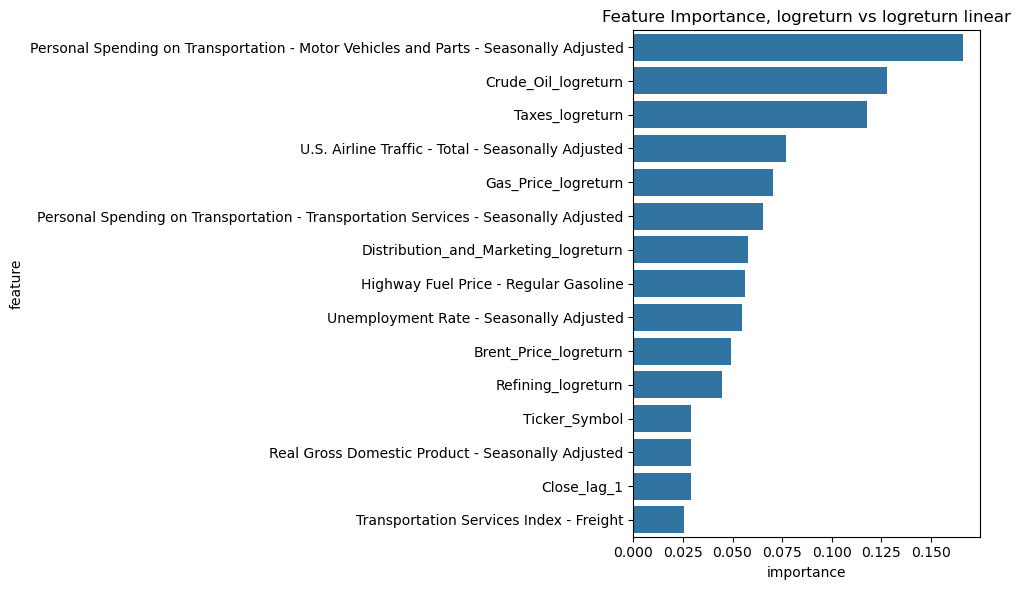

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()